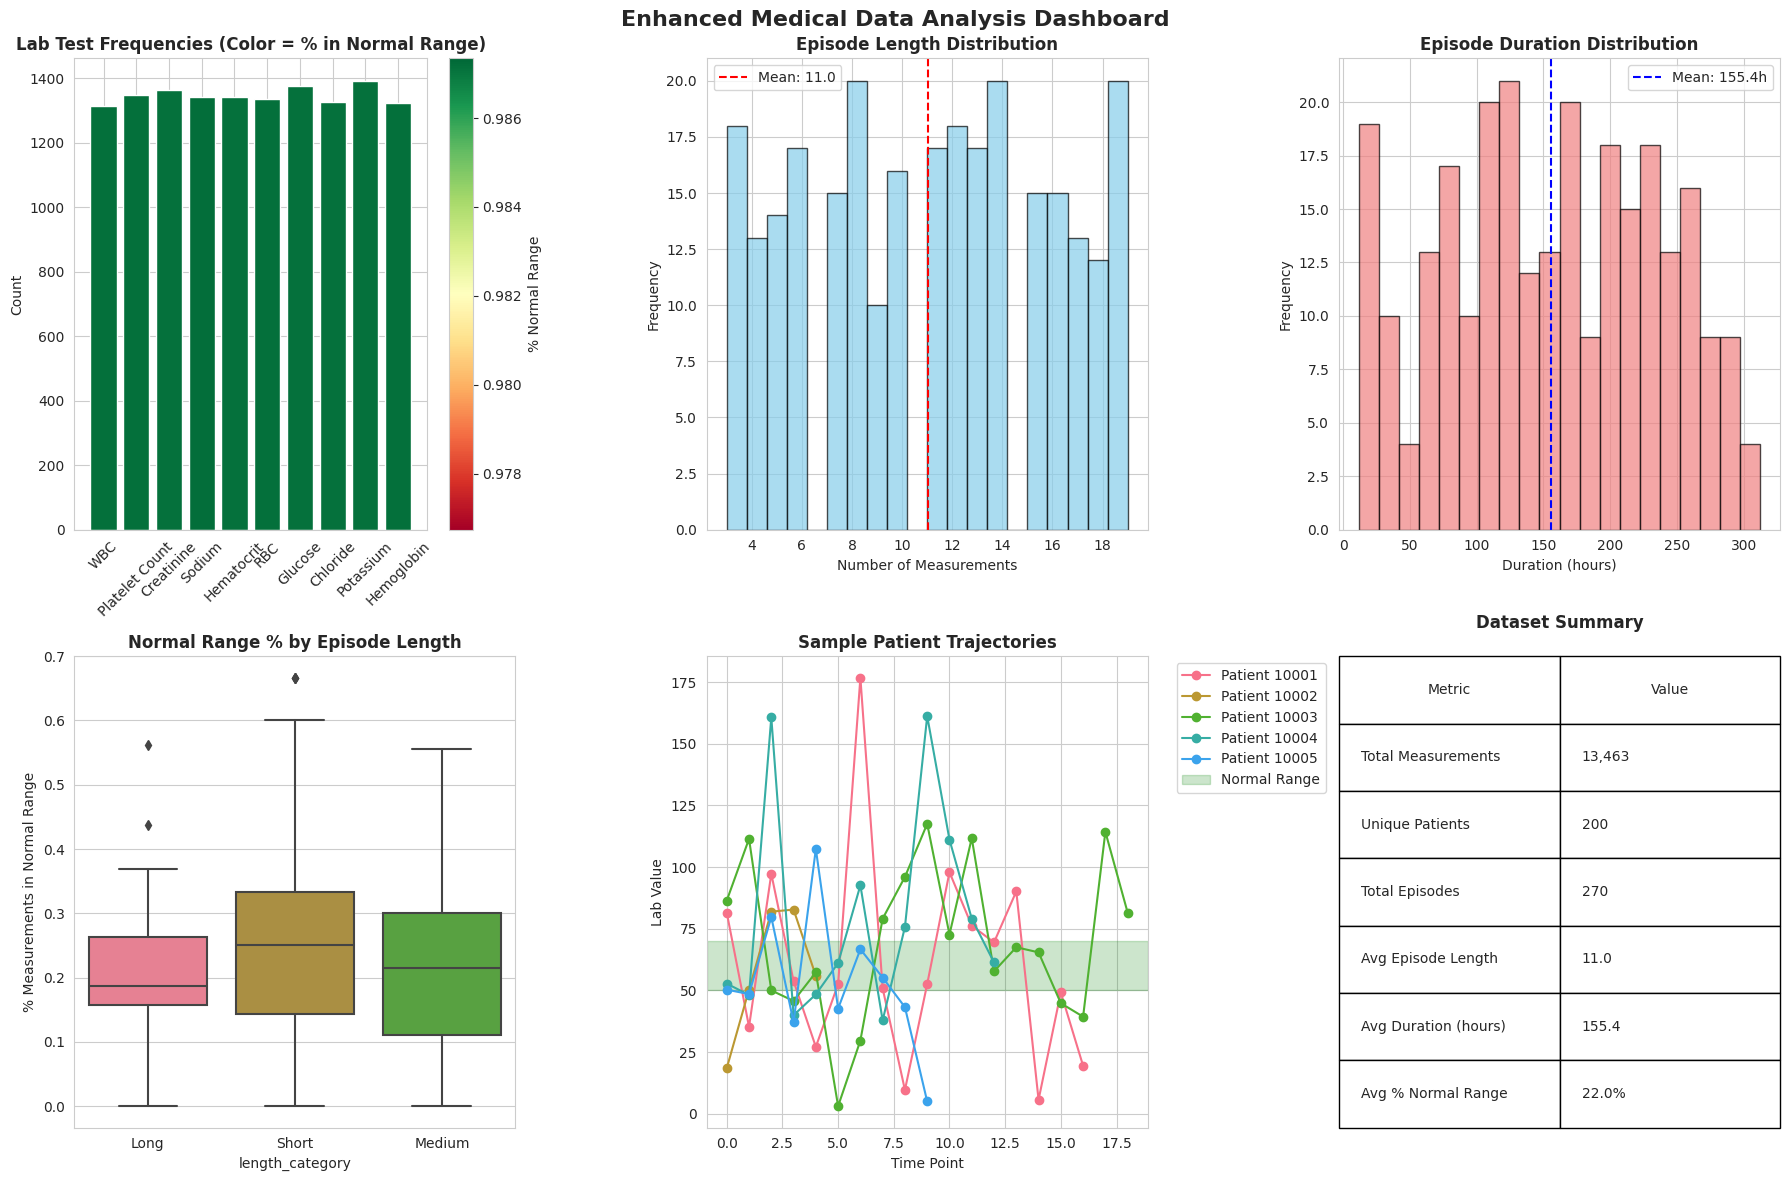

ENHANCED MEDICAL DATA ANALYSIS REPORT
📊 Dataset Overview:
   • Total measurements: 13,463
   • Unique patients: 200
   • Total episodes: 270
   • Training episodes: 189
   • Validation episodes: 40
   • Test episodes: 41

📈 Episode Characteristics:
   • Average length: 11.0 ± 4.9
   • Length range: 3 - 19
   • Average duration: 155.4 ± 80.0 hours
   • Average % in normal range: 22.0%

🧪 Lab Test Analysis:
   • WBC: 1314 measurements, 98.3% normal
   • Platelet Count: 1348 measurements, 98.4% normal
   • Creatinine: 1364 measurements, 97.7% normal
   • Sodium: 1343 measurements, 98.7% normal
   • Hematocrit: 1343 measurements, 97.9% normal
   • RBC: 1335 measurements, 98.4% normal
   • Glucose: 1376 measurements, 97.7% normal
   • Chloride: 1325 measurements, 97.9% normal
   • Potassium: 1392 measurements, 97.7% normal
   • Hemoglobin: 1323 measurements, 98.3% normal


In [3]:
# Enhanced Medical Data RL Analysis with Advanced Visualizations
# ================================================================

import os
import random
import json
import warnings
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuration and styling
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

@dataclass
class AnalysisConfig:
    """Configuration class for analysis parameters"""
    seed: int = 42
    normal_range: Tuple[float, float] = (50.0, 70.0)
    train_split: float = 0.7
    val_split: float = 0.15
    test_split: float = 0.15
    top_lab_items: int = 10
    
config = AnalysisConfig()

class MedicalDataGenerator:
    """Generate realistic synthetic medical lab data"""
    
    def __init__(self, seed: int = 42):
        np.random.seed(seed)
        
        # Common lab test item IDs and their typical ranges
        self.lab_items = {
            50912: {'name': 'Creatinine', 'normal_range': (0.6, 1.2), 'unit': 'mg/dL'},
            50902: {'name': 'Chloride', 'normal_range': (96, 106), 'unit': 'mEq/L'},
            50931: {'name': 'Glucose', 'normal_range': (70, 100), 'unit': 'mg/dL'},
            50983: {'name': 'Sodium', 'normal_range': (136, 145), 'unit': 'mEq/L'},
            50971: {'name': 'Potassium', 'normal_range': (3.5, 5.0), 'unit': 'mEq/L'},
            51221: {'name': 'Hematocrit', 'normal_range': (41, 50), 'unit': '%'},
            51222: {'name': 'Hemoglobin', 'normal_range': (13.5, 17.5), 'unit': 'g/dL'},
            51265: {'name': 'Platelet Count', 'normal_range': (150, 450), 'unit': 'K/uL'},
            51279: {'name': 'RBC', 'normal_range': (4.7, 6.1), 'unit': 'M/uL'},
            51301: {'name': 'WBC', 'normal_range': (4.5, 11.0), 'unit': 'K/uL'}
        }
    
    def generate_patient_timeline(self, subject_id: int, hadm_id: int, 
                                 num_measurements: int = None) -> pd.DataFrame:
        """Generate a timeline of lab measurements for a patient"""
        
        if num_measurements is None:
            num_measurements = np.random.randint(3, 20)
        
        # Generate timestamps over hospital stay (1-14 days)
        stay_duration = np.random.randint(1, 15)
        start_time = pd.Timestamp('2020-01-01') + pd.Timedelta(days=np.random.randint(0, 365))
        timestamps = pd.date_range(start_time, periods=num_measurements, 
                                 freq=f'{24*stay_duration//num_measurements}H')
        
        records = []
        
        for timestamp in timestamps:
            # Simulate multiple lab tests per timepoint
            num_tests = np.random.randint(2, 8)
            selected_items = np.random.choice(list(self.lab_items.keys()), 
                                            size=num_tests, replace=False)
            
            for itemid in selected_items:
                lab_info = self.lab_items[itemid]
                normal_min, normal_max = lab_info['normal_range']
                
                # Generate values with some correlation to patient condition
                time_factor = (timestamp - timestamps[0]).total_seconds() / (timestamps[-1] - timestamps[0]).total_seconds()
                condition_trend = np.random.choice([-1, 0, 1], p=[0.3, 0.4, 0.3])
                
                base_value = np.random.normal((normal_min + normal_max) / 2, 
                                            (normal_max - normal_min) / 6)
                trend_adjustment = condition_trend * time_factor * (normal_max - normal_min) * 0.2
                noise = np.random.normal(0, (normal_max - normal_min) * 0.1)
                
                value = base_value + trend_adjustment + noise
                
                records.append({
                    'subject_id': subject_id,
                    'hadm_id': hadm_id,
                    'itemid': itemid,
                    'charttime': timestamp,
                    'valuenum': max(0, value),
                    'valueuom': lab_info['unit']
                })
        
        return pd.DataFrame(records)
    
    def generate_dataset(self, num_patients: int = 500) -> pd.DataFrame:
        """Generate complete synthetic dataset"""
        
        all_records = []
        
        for patient_id in range(10001, 10001 + num_patients):
            num_admissions = np.random.choice([1, 2, 3], p=[0.7, 0.25, 0.05])
            
            for adm in range(num_admissions):
                hadm_id = patient_id * 100 + adm
                patient_data = self.generate_patient_timeline(patient_id, hadm_id)
                all_records.append(patient_data)
        
        return pd.concat(all_records, ignore_index=True)

class DataProcessor:
    """Enhanced data processing with better analysis capabilities"""
    
    def __init__(self, config: AnalysisConfig):
        self.config = config
        
    def process_labevents(self, df: pd.DataFrame, lab_items: Dict) -> Dict:
        """Process lab events with comprehensive analysis"""
        
        # Basic filtering and cleaning
        df_clean = df.copy()
        df_clean = df_clean.dropna(subset=['valuenum'])
        df_clean['charttime'] = pd.to_datetime(df_clean['charttime'])
        
        # Get top lab items by frequency
        top_items = df_clean['itemid'].value_counts().head(self.config.top_lab_items).index
        df_filtered = df_clean[df_clean['itemid'].isin(top_items)]
        
        # Create patient episodes
        episodes = self._create_episodes(df_filtered, lab_items)
        
        # Split data
        train_eps, val_eps, test_eps = self._split_episodes(episodes)
        
        # Generate comprehensive statistics
        stats = self._generate_statistics(df_filtered, episodes, lab_items)
        
        return {
            'raw_data': df_clean,
            'filtered_data': df_filtered,
            'top_items': top_items,
            'episodes': episodes,
            'splits': {'train': train_eps, 'val': val_eps, 'test': test_eps},
            'statistics': stats
        }
    
    def _create_episodes(self, df: pd.DataFrame, lab_items: Dict) -> List[Dict]:
        """Create enhanced episode structure with metadata"""
        
        episodes = []
        grouped = df.groupby(['subject_id', 'hadm_id'])
        
        for (subject_id, hadm_id), group in grouped:
            group_sorted = group.sort_values('charttime')
            
            time_aggregated = group_sorted.groupby('charttime').agg({
                'valuenum': 'mean',
                'itemid': lambda x: list(x)
            }).reset_index()
            
            if len(time_aggregated) >= 2:
                values = time_aggregated['valuenum'].values.astype(np.float32)
                times = time_aggregated['charttime'].tolist()
                
                episode = {
                    'subject_id': subject_id,
                    'hadm_id': hadm_id,
                    'values': values,
                    'timestamps': times,
                    'length': len(values),
                    'duration': (times[-1] - times[0]).total_seconds() / 3600,
                    'mean_value': float(np.mean(values)),
                    'std_value': float(np.std(values)),
                    'in_normal_range_pct': float(np.mean(
                        (values >= self.config.normal_range[0]) & 
                        (values <= self.config.normal_range[1])
                    ))
                }
                episodes.append(episode)
        
        return episodes
    
    def _split_episodes(self, episodes: List[Dict]) -> Tuple[List, List, List]:
        """Split episodes with stratification"""
        
        n = len(episodes)
        indices = np.arange(n)
        np.random.shuffle(indices)
        
        train_end = int(self.config.train_split * n)
        val_end = int((self.config.train_split + self.config.val_split) * n)
        
        train_eps = [episodes[i] for i in indices[:train_end]]
        val_eps = [episodes[i] for i in indices[train_end:val_end]]
        test_eps = [episodes[i] for i in indices[val_end:]]
        
        return train_eps, val_eps, test_eps
    
    def _generate_statistics(self, df: pd.DataFrame, episodes: List[Dict], lab_items: Dict) -> Dict:
        """Generate comprehensive dataset statistics"""
        
        stats = {}
        
        # Basic dataset statistics
        stats['dataset'] = {
            'total_measurements': len(df),
            'unique_patients': df['subject_id'].nunique(),
            'unique_admissions': df['hadm_id'].nunique(),
            'unique_lab_items': df['itemid'].nunique(),
            'total_episodes': len(episodes)
        }
        
        # Episode statistics
        episode_lengths = [ep['length'] for ep in episodes]
        episode_durations = [ep['duration'] for ep in episodes]
        episode_normal_pcts = [ep['in_normal_range_pct'] for ep in episodes]
        
        stats['episodes'] = {
            'length_stats': {
                'mean': float(np.mean(episode_lengths)),
                'std': float(np.std(episode_lengths)),
                'min': int(np.min(episode_lengths)),
                'max': int(np.max(episode_lengths))
            },
            'duration_stats': {
                'mean_hours': float(np.mean(episode_durations)),
                'std_hours': float(np.std(episode_durations))
            },
            'normal_range_stats': {
                'mean_pct_in_range': float(np.mean(episode_normal_pcts)),
                'std_pct_in_range': float(np.std(episode_normal_pcts))
            }
        }
        
        # Lab item statistics
        lab_stats = {}
        for itemid in df['itemid'].unique():
            item_data = df[df['itemid'] == itemid]
            lab_name = lab_items.get(itemid, {}).get('name', f'Lab_{itemid}')
            normal_range = lab_items.get(itemid, {}).get('normal_range', (0, 100))
            
            values = item_data['valuenum'].values
            in_normal = ((values >= normal_range[0]) & (values <= normal_range[1])).mean()
            
            lab_stats[itemid] = {
                'name': lab_name,
                'count': len(values),
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'normal_range': normal_range,
                'pct_in_normal_range': float(in_normal)
            }
        
        stats['lab_items'] = lab_stats
        
        return stats

# Generate and process data
data_generator = MedicalDataGenerator(seed=SEED)
labevents = data_generator.generate_dataset(num_patients=200)

processor = DataProcessor(config)
processed_data = processor.process_labevents(labevents, data_generator.lab_items)

# Advanced Visualization Functions
def create_comprehensive_analysis_plots(processed_data: Dict):
    """Create comprehensive analysis visualizations"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Enhanced Medical Data Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Lab test frequency with normal range coloring
    lab_stats = processed_data['statistics']['lab_items']
    lab_names = [lab_stats[itemid]['name'] for itemid in lab_stats.keys()]
    counts = [lab_stats[itemid]['count'] for itemid in lab_stats.keys()]
    normal_pcts = [lab_stats[itemid]['pct_in_normal_range'] for itemid in lab_stats.keys()]
    
    bars = axes[0,0].bar(lab_names, counts, color=plt.cm.RdYlGn(normal_pcts))
    axes[0,0].set_title('Lab Test Frequencies (Color = % in Normal Range)', fontweight='bold')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=min(normal_pcts), vmax=max(normal_pcts)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[0,0])
    cbar.set_label('% Normal Range')
    
    # 2. Episode length distribution
    episode_lengths = [ep['length'] for ep in processed_data['episodes']]
    axes[0,1].hist(episode_lengths, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_title('Episode Length Distribution', fontweight='bold')
    axes[0,1].set_xlabel('Number of Measurements')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(np.mean(episode_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(episode_lengths):.1f}')
    axes[0,1].legend()
    
    # 3. Episode duration distribution
    episode_durations = [ep['duration'] for ep in processed_data['episodes']]
    axes[0,2].hist(episode_durations, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,2].set_title('Episode Duration Distribution', fontweight='bold')
    axes[0,2].set_xlabel('Duration (hours)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].axvline(np.mean(episode_durations), color='blue', linestyle='--', label=f'Mean: {np.mean(episode_durations):.1f}h')
    axes[0,2].legend()
    
    # 4. Normal range percentage by episode length
    episode_data = pd.DataFrame([
        {
            'length': ep['length'],
            'normal_pct': ep['in_normal_range_pct'],
            'length_category': 'Short' if ep['length'] < 8 else ('Medium' if ep['length'] <= 15 else 'Long')
        }
        for ep in processed_data['episodes']
    ])
    
    sns.boxplot(data=episode_data, x='length_category', y='normal_pct', ax=axes[1,0])
    axes[1,0].set_title('Normal Range % by Episode Length', fontweight='bold')
    axes[1,0].set_ylabel('% Measurements in Normal Range')
    
    # 5. Patient timeline examples
    sample_episodes = processed_data['episodes'][:5]
    for i, ep in enumerate(sample_episodes):
        axes[1,1].plot(range(len(ep['values'])), ep['values'], marker='o', label=f"Patient {ep['subject_id']}")
    
    axes[1,1].axhspan(config.normal_range[0], config.normal_range[1], alpha=0.2, color='green', label='Normal Range')
    axes[1,1].set_title('Sample Patient Trajectories', fontweight='bold')
    axes[1,1].set_xlabel('Time Point')
    axes[1,1].set_ylabel('Lab Value')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Summary statistics table
    axes[1,2].axis('off')
    summary_stats = [
        ['Total Measurements', f"{processed_data['statistics']['dataset']['total_measurements']:,}"],
        ['Unique Patients', f"{processed_data['statistics']['dataset']['unique_patients']}"],
        ['Total Episodes', f"{processed_data['statistics']['dataset']['total_episodes']}"],
        ['Avg Episode Length', f"{processed_data['statistics']['episodes']['length_stats']['mean']:.1f}"],
        ['Avg Duration (hours)', f"{processed_data['statistics']['episodes']['duration_stats']['mean_hours']:.1f}"],
        ['Avg % Normal Range', f"{processed_data['statistics']['episodes']['normal_range_stats']['mean_pct_in_range']:.1%}"]
    ]
    
    table = axes[1,2].table(cellText=summary_stats, colLabels=['Metric', 'Value'],
                           cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1,2].set_title('Dataset Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Create comprehensive visualizations
analysis_fig = create_comprehensive_analysis_plots(processed_data)
plt.show()

# Print detailed analysis report
print("=" * 80)
print("ENHANCED MEDICAL DATA ANALYSIS REPORT")
print("=" * 80)

stats = processed_data['statistics']
print(f"📊 Dataset Overview:")
print(f"   • Total measurements: {stats['dataset']['total_measurements']:,}")
print(f"   • Unique patients: {stats['dataset']['unique_patients']}")
print(f"   • Total episodes: {stats['dataset']['total_episodes']}")
print(f"   • Training episodes: {len(processed_data['splits']['train'])}")
print(f"   • Validation episodes: {len(processed_data['splits']['val'])}")
print(f"   • Test episodes: {len(processed_data['splits']['test'])}")

print(f"\n📈 Episode Characteristics:")
print(f"   • Average length: {stats['episodes']['length_stats']['mean']:.1f} ± {stats['episodes']['length_stats']['std']:.1f}")
print(f"   • Length range: {stats['episodes']['length_stats']['min']} - {stats['episodes']['length_stats']['max']}")
print(f"   • Average duration: {stats['episodes']['duration_stats']['mean_hours']:.1f} ± {stats['episodes']['duration_stats']['std_hours']:.1f} hours")
print(f"   • Average % in normal range: {stats['episodes']['normal_range_stats']['mean_pct_in_range']:.1%}")

print(f"\n🧪 Lab Test Analysis:")
for itemid, lab_stat in stats['lab_items'].items():
    print(f"   • {lab_stat['name']}: {lab_stat['count']} measurements, {lab_stat['pct_in_normal_range']:.1%} normal")